In [167]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
np.random.seed(1)
from mogp import MultiOutputMarginal

In [148]:
df = pd.read_csv("../data/economy/econ_metrics.csv")
df.shape

(201, 6)

In [149]:
df.head()

,Date,Fed Rate,unemployment,sp500,nasdaq,bitcoin
0,2006-01-01,4.29,4.7,1278.723000,2287.434033,NaN
1,2006-02-01,4.49,4.8,1276.645263,2283.470032,NaN
2,2006-03-01,4.59,4.7,1293.740000,2305.282532,NaN
3,2006-04-01,4.79,4.7,1302.183684,2332.640075,NaN
4,2006-05-01,4.94,4.6,1290.000000,2242.002002,NaN


In [150]:
df["Date"] = pd.to_datetime(df["Date"])
df = df.set_index("Date")

In [151]:
df.describe()

,Fed Rate,unemployment,sp500,nasdaq,bitcoin
count,200.00000,200.000000,201.000000,201.000000,97.000000
mean,1.15295,6.145000,2101.869353,5401.326350,12652.810296
std,1.61951,2.182888,987.781525,3699.380190,16323.689647
min,0.05000,3.500000,757.126818,1469.937988,229.635250
25%,0.10000,4.400000,1323.484286,2497.232483,665.767993
50%,0.19000,5.400000,1889.767143,4235.352539,6702.184936
75%,1.81250,7.900000,2705.155263,7296.144043,12408.956055
max,5.26000,14.700000,4674.772727,15693.424024,59643.747071


In [152]:
columns = ["Fed Rate","unemployment", "sp500", "nasdaq"]
df[columns] = (df[columns] - df[columns].mean()) / df[columns].std()
df = df.drop(columns="bitcoin")
df = df.dropna()
df.shape

(200, 4)

In [153]:
df.head()

,Fed Rate,unemployment,sp500,nasdaq
Date,,,,
2006-01-01,1.937036,-0.661967,-0.833328,-0.841734
2006-02-01,2.060530,-0.616156,-0.835432,-0.842805
2006-03-01,2.122277,-0.661967,-0.818126,-0.836909
2006-04-01,2.245771,-0.661967,-0.809577,-0.829514
2006-05-01,2.338392,-0.707778,-0.821912,-0.854015


In [154]:
df["x"] = range(df.shape[0])
df

,Fed Rate,unemployment,sp500,nasdaq,x
Date,,,,,
2006-01-01,1.937036,-0.661967,-0.833328,-0.841734,0
2006-02-01,2.060530,-0.616156,-0.835432,-0.842805,1
2006-03-01,2.122277,-0.661967,-0.818126,-0.836909,2
2006-04-01,2.245771,-0.661967,-0.809577,-0.829514,3
2006-05-01,2.338392,-0.707778,-0.821912,-0.854015,4
...,...,...,...,...,...
2022-04-01,-0.508147,-1.165887,2.317746,2.069989,195
2022-05-01,-0.236460,-1.165887,1.962469,1.753889,196
2022-06-01,0.035227,-1.165887,1.819306,1.572462,197


<AxesSubplot:xlabel='Date'>

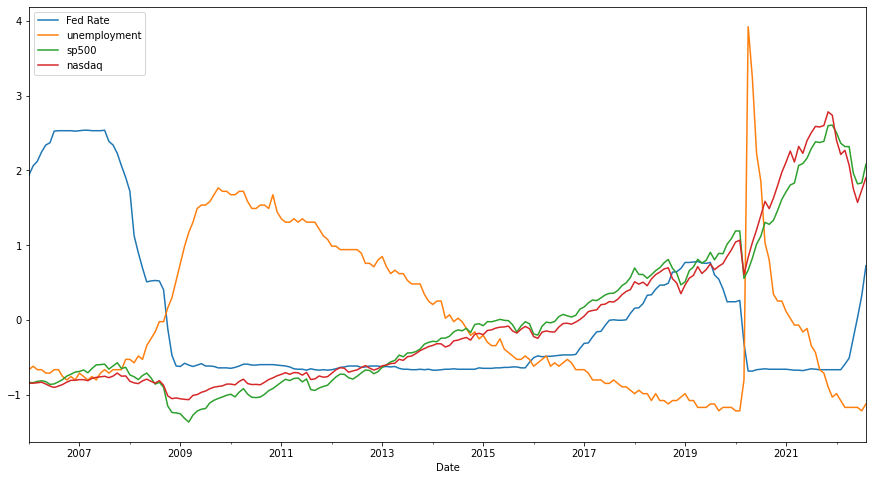

In [155]:
df[columns].plot(figsize=(15, 8))

### 1: Implement ICM (one kernel) by using pm.gp.cov.Kron

$$
K = K_1(x, x') \otimes K_2(o, o')
$$

In [156]:
adf = df.head(50)
adf.shape

(50, 5)

<AxesSubplot:xlabel='Date'>

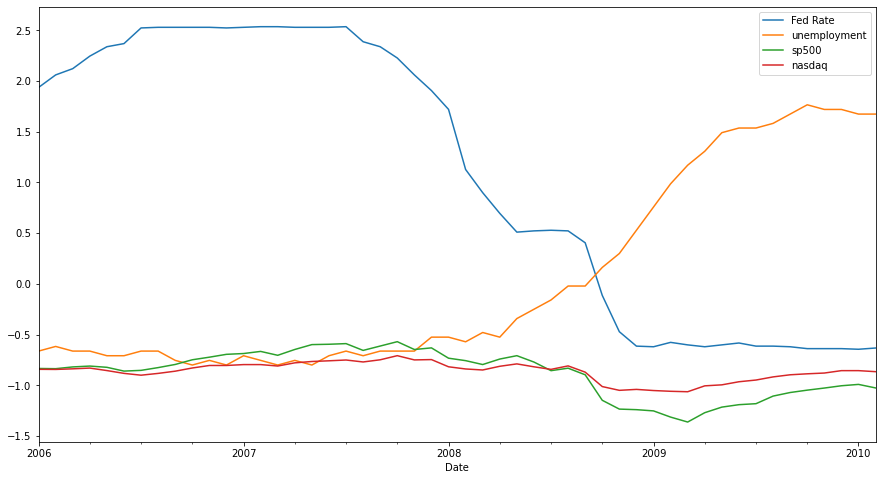

In [157]:
adf[columns].plot(figsize=(15, 8))

In [158]:
columns = ["Fed Rate", "sp500", "nasdaq"]
x = adf['x'].values.reshape(-1,1)
y = adf[columns].values.reshape(-1,1)
task_i = np.linspace(0, 2, 3)[:, None]
X = pm.math.cartesian(x, task_i)
x.shape, task_i.shape, X.shape

((50, 1), (3, 1), (150, 2))

In [159]:
X.shape, y.shape

((150, 2), (150, 1))

In [160]:
import aesara.tensor as at
with pm.Model() as model:
    ell = pm.Gamma("ell", alpha=2, beta=0.5)
    eta = pm.Gamma("eta", alpha=3, beta=1)
    cov = eta**2 * pm.gp.cov.ExpQuad(1, ls=ell)
    
    
    
    W = pm.Normal("W", mu=0, sigma=3, shape=(3,2), initval=np.random.randn(3,2))
    kappa = pm.Gamma("kappa", alpha=1.5, beta=1, shape=3)
    B = pm.Deterministic('B', at.dot(W, W.T) + at.diag(kappa))
    sigma = pm.HalfNormal("sigma", sigma=3)
    
    mogp = MultiOutputMarginal(means=0, kernels=[cov], num_outputs=3, same_input=True, input_dim=1, B=B)
    y_ = mogp.marginal_likelihood("f", X, y.squeeze(), noise=sigma)

In [161]:
%%time
with model:
    gp_trace = pm.sample(500, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [ell, eta, W, kappa, sigma]


Sampling 1 chain for 1_000 tune and 500 draw iterations (1_000 + 500 draws total) took 469 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


CPU times: user 22min 39s, sys: 39min 32s, total: 1h 2min 12s
Wall time: 7min 54s


#### Prediction

In [162]:
M = 55
xnew = np.linspace(0, M, M)[:, None]
Xnew = pm.math.cartesian(xnew, task_i) # For prediction
Xnew.shape

(165, 2)

In [163]:
%%time
with model:
    preds = mogp.conditional("preds", Xnew, jitter=1e-6)
    gp_samples = pm.sample_posterior_predictive(gp_trace, var_names=['preds'])

CPU times: user 13.5 s, sys: 17.5 s, total: 31 s
Wall time: 4.97 s


In [164]:
f_pred = gp_samples.posterior_predictive["preds"].sel(chain=0)
f_pred.shape

(500, 165)

#### Plot the GP prediction

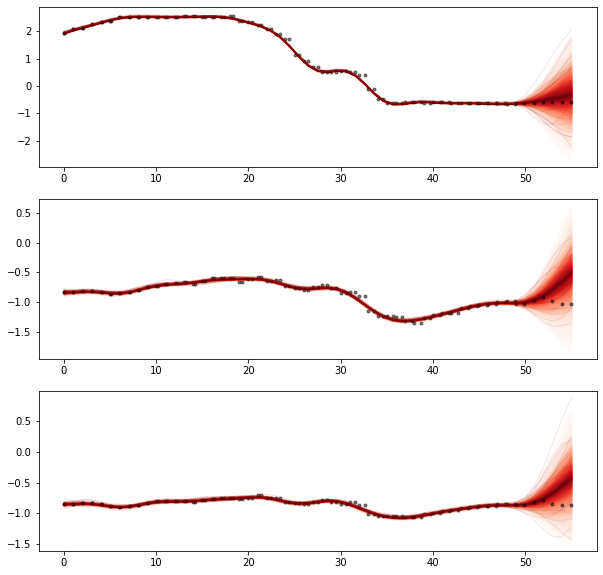

In [165]:
import matplotlib.pyplot as plt
from pymc.gp.util import plot_gp_dist
fig, axes = plt.subplots(3,1, figsize=(10,10))

for idx in range(3):
    axes[idx].plot(xnew, df.head(M)[columns].values[:,idx], 'ok', ms=3, alpha=0.5, label=f"Data {idx}");
    axes[idx].plot(x, adf[columns].values[:,idx], 'ok', ms=3, alpha=0.5, label=f"Data {idx}");
    plot_gp_dist(axes[idx], f_pred[:,Xnew[:,1] == idx], xnew,
                 fill_alpha=0.5, samples_alpha=0.1)

plt.show()

In [168]:
az.summary(gp_trace)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"W[0, 0]",0.451,5.337,-8.324,8.190,0.535,0.379,112.0,336.0,NaN
"W[0, 1]",0.046,5.133,-8.055,8.677,0.552,0.392,95.0,274.0,NaN
"W[1, 0]",0.014,2.440,-3.638,4.269,0.294,0.209,88.0,239.0,NaN
"W[1, 1]",-0.205,2.517,-3.786,4.316,0.253,0.179,105.0,243.0,NaN
"W[2, 0]",-0.018,2.285,-3.465,3.946,0.296,0.210,78.0,248.0,NaN
"W[2, 1]",-0.194,2.286,-3.662,3.916,0.224,0.159,109.0,207.0,NaN
ell,4.088,0.179,3.788,4.478,0.011,0.008,275.0,174.0,NaN
eta,0.191,0.052,0.111,0.287,0.004,0.003,156.0,209.0,NaN
kappa[0],1.438,1.274,0.030,3.647,0.095,0.067,110.0,77.0,NaN
kappa[1],0.165,0.177,0.005,0.481,0.010,0.007,241.0,166.0,NaN


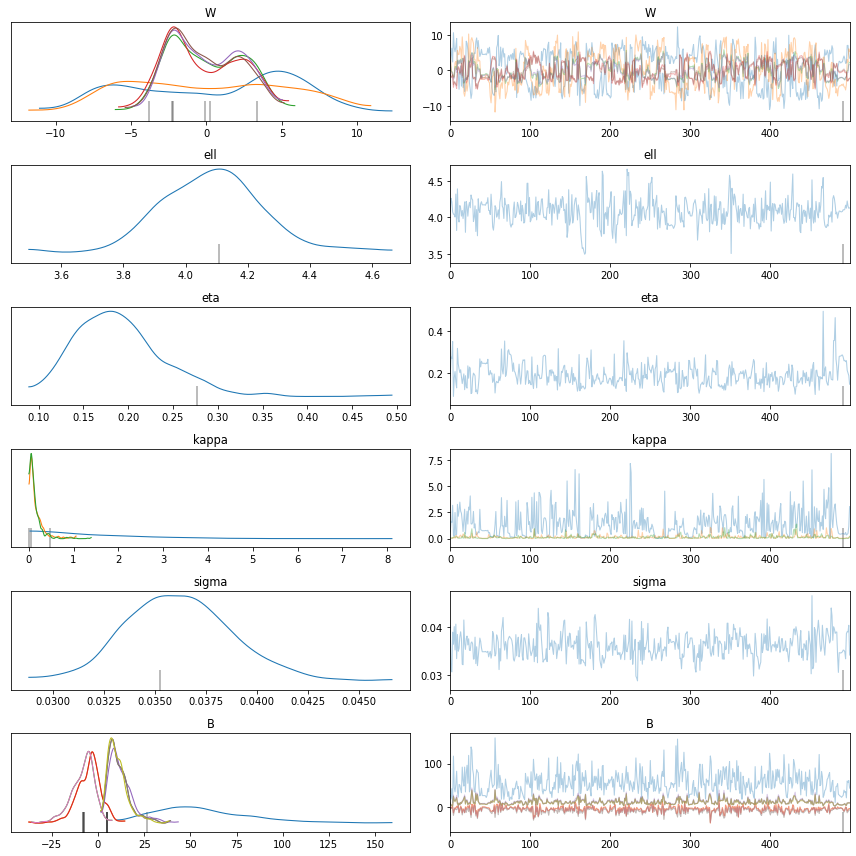

In [169]:
az.plot_trace(gp_trace);
plt.tight_layout()